In [220]:
import numpy as np
import random
import time
from itertools import chain

import tensorflow as tf
import keras
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, Concatenate, Activation, GRU, SimpleRNN
from keras.models import Model
from keras.utils import np_utils
from keras import regularizers
import os
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import pandas as pd
import collections
import re
import math
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
import sys
from fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
matplotlib.use('pdf')

In [221]:
# 元データのファイル構造のままで実行できるようにするにはos.walk()とか使えば良さそう。
# subjects=['A','B','C','D','E','F','G','H','I']
# subjects=['A','B','C','D','E','I']
# エキスパートの中でも異常発見数が多い人、経験年数が長い人を選ぶ
subjects=['A','D','E','F','G','I']
sub_level={'A':'E','B':'E','C':'E','D':'N','E':'N','F':'E','G':'E','H':'E','I':'N'}
sub_heights={'A':1.680,'B':1.780,'C':1.750,'D':1.750,'E':1.700,'F':1.680,'G':1.710,'H':1.658,'I':1.670}
eng_to_num={'A':'1','B':'2','C':'3','D':'4','E':'5','F':'6','G':'7','H':'8','I':'9'}
num_to_eng={'1':'A','2':'B','3':'C','4':'D','5':'E','6':'F','7':'G','8':'H','9':'I'}
log_type='Eyelog'
# logのB002(3回目)がない。それに対応するB10のエクセルもない。
path_to_original_log='./log'
path_to_excel='./視線分析'
classes = ['E', 'N']

root_path='./OIL_DATA'
path_to_log=root_path+'/'+log_type
path_to_new_log=path_to_log+'/log_data'
path_to_transcriptions=path_to_log+'/transcriptions'
path_to_supertrialout=root_path+'/Experimental_setup/Eyelog/unBalanced/GestureClassification/SuperTrialOut'

In [222]:
def create_dir(out_dir):
    if os.path.exists(out_dir):
        return None
    else:
        try:
            os.makedirs(out_dir)
        except:
            # in case another machine created the path meanwhile
            return None
        return out_dir

def readFile(file_name, dtype, columns_to_use=None):
    X = np.loadtxt(file_name, dtype, usecols=columns_to_use)
    return X


In [223]:
encoder = LabelEncoder()  # used to transform labels into binary one hot vectors

def fit_encoder(y_train, y_test, y_val):
    y_train_test_val = y_train + y_test + y_val
    encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train, y_test, y_val):
    idx_y_test = len(y_train)
    idx_y_val = len(y_train) + len(y_test)
    y_train_test_val = y_train + y_test + y_val
    y_train_test_val = encoder.transform(y_train_test_val)
    y_train_test_val = np_utils.to_categorical(y_train_test_val)
    y_train = y_train_test_val[0:idx_y_test]
    y_test = y_train_test_val[idx_y_test:idx_y_val]
    y_val = y_train_test_val[idx_y_val:]
    return y_train, y_test, y_val

# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train
def split_input_for_training(sequence):
    # get number of hands
    num_hands = len(input_shapes)
    # get number of dimensions cluster for each hand
    num_dim_clusters = len(input_shapes[0])
    # define the new input sequence
    x = []
    # this is used to keep track of the assigned dimensions
    last = 0
    # loop over each hand
    for i in range(num_hands):
        # loop for each hand over the cluster of dimensions
        for j in range(num_dim_clusters):
            # assign new input same length but different dimensions each time
            x.append(np.array([sequence[:, last:(last + input_shapes[i][j][1])]]))
            # remember last assigned
            last = input_shapes[i][j][1]
    # return the new input
    return x

# shuffles train and labels
def shuffle(x_train, y_train):
    y_train = np.array(y_train)
    y_train = y_train.reshape(len(y_train), 1)
    x_train = x_train.reshape(len(x_train), 1)
    x_y_train = np.concatenate((x_train, y_train), axis=1)
    np.random.shuffle(x_y_train)
    return x_y_train[:, 0], x_y_train[:, 1].tolist()

def evaluate_for_epoch(model, x_test, y_test):
    epoch_test_loss = 0
    for test, label in zip(x_test, y_test):
        loss, acc = model.evaluate(split_input_for_training(test), label.reshape(1, nb_classes), verbose=0)
        epoch_test_loss += loss  ############### change if monitor loss instead of accuracy
    return epoch_test_loss / len(x_test)

In [224]:
def evaluateModel(model, x_test, y_test_binary):
    confusion_matrix_f = pd.DataFrame(np.zeros(shape=(nb_classes, nb_classes)), index=list(map(lambda str:'pred_'+str,classes)), columns=list(map(lambda str:'true_'+str,classes)))

    for test, label in zip(x_test, y_test_binary):
        model.evaluate(split_input_for_training(test), label.reshape(1, nb_classes), verbose=0)
        p = model.predict(split_input_for_training(test), batch_size=1)
        predicted_integer_label = np.argmax(p).astype(int)
        predicted_label = encoder.inverse_transform([predicted_integer_label])[0]
        correct_label = encoder.inverse_transform([np.argmax(label)])[0]
        confusion_matrix_f['true_'+correct_label]['pred_'+predicted_label] += 1.0
        confusion_matrix['true_'+correct_label]['pred_'+predicted_label] += 1.0

    # print(confusion_matrix_f)
    return confusion_matrix_f

    # matrix_f = confusion_matrix_f.values
    # macro = compute_macro(matrix_f)
    # return (macro, compute_micro(matrix_f), compute_precision(matrix_f)
    #         , compute_macro_std(macro, matrix_f), compute_precision_std(macro, matrix_f))

def evaluate_confusion_matrix(df,index,confusion_matrix,process_time):
    if index=='overall':
        df.loc[index,'TP']=df['TP'].sum()
        df.loc[index,'TN']=df['TN'].sum()
        df.loc[index,'FP']=df['FP'].sum()
        df.loc[index,'FN']=df['FN'].sum()
        df.loc[index,'accuracy'] = df['accuracy'].mean()
        df.loc[index,'precision'] = df['precision'].mean()
        df.loc[index,'recall'] = df['recall'].mean()
        df.loc[index,'f_measure'] = df['f_measure'].mean()
        df.loc[index,'process_time']=df['process_time'].mean()
        df.to_csv(out_dir + 'df_metrics.csv')
    else:
        tp=confusion_matrix['true_E']['pred_E']
        tn=confusion_matrix['true_N']['pred_N']
        fp=confusion_matrix['true_N']['pred_E']
        fn=confusion_matrix['true_E']['pred_N']
        accuracy=(tp+fn)/(tp+fp+fn+tn)
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        f_measure=(2*precision*recall)/(precision+recall)

        df.loc[index,'TP']=tp
        df.loc[index,'TN']=tn
        df.loc[index,'FP']=fp
        df.loc[index,'FN']=fn
        df.loc[index,'accuracy'] = accuracy
        df.loc[index,'precision'] = precision
        df.loc[index,'recall'] = recall
        df.loc[index,'f_measure'] = f_measure
        df.loc[index,'process_time']=process_time
    

In [225]:
def make_datasets(test_num):
    x_train=[]
    x_val=[]
    x_test=[]
    y_train=[]
    y_val=[]
    y_test=[]
    for subject in subjects:
        for trial_num in range(0,10):
            df_log=pd.read_table('../OIL_DATA/Eyelog/log_data/Eyelog_'+subject+'00'+str(trial_num)+'.txt', header=None)
            if trial_num==test_num:
                x_test.append(df_log.values)
                if sub_level[subject]=='N':
                    y_test.append('N')
                elif sub_level[subject]=='E':
                    y_test.append('E')
            else:
                x_train.append(df_log.values)
                if sub_level[subject]=='N':
                    y_train.append('N')
                elif sub_level[subject]=='E':
                    y_train.append('E')
    x_train=np.array(x_train, dtype=object)
    x_test=np.array(x_test, dtype=object)
    x_val=np.array(x_val,dtype=object)
    fit_encoder(y_train, y_test, y_val)
    return x_train,y_train,x_test,y_test,x_val,y_val

In [226]:
def modified_fcn_each_dim_build_model(input_shapes, filters, kernel_size, lr, amsgrad, summary=False, reg=0.01):
    # num_hands=1,num_dim_clusters=2
    # get number of hands
    num_hands = len(input_shapes)
    # get number of dimensions cluster for each hand
    num_dim_clusters = len(input_shapes[0])

    ip = [None for a in range(0, num_dim_clusters)]
    x = [None for a in range(0, num_dim_clusters)]
    
    for i in range(0,num_dim_clusters):
        ip[i] = Input(input_shapes[0][i])
        x[i] = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                                              activity_regularizer=regularizers.l2(reg))(ip[i])
        # x[i] = BatchNormalization()(x[i])
        x[i] = Activation('relu')(x[i])
        # x[i] = Dropout(0.5)(x[i])
    final_input=Concatenate(axis=-1)(x)
    X = Conv1D(filters=2 * filters, kernel_size=kernel_size, strides=1, padding='same',
                                activity_regularizer=regularizers.l2(reg))(final_input)
    # bn2 = BatchNormalization()(conv2)
    X = Activation('relu', name="conv_final")(X)


    # do a globla average pooling of the final convolution
    X = GlobalAveragePooling1D()(X)
    # add the final softmax classifier layer
    out = Dense(nb_classes, activation='sigmoid')(X)
    
    # create the model and link input to output
    model = Model(inputs=ip, outputs=out)
    # show summary if specified
    if summary == True:
        model.summary()

    import tensorflow as tf
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr,amsgrad=amsgrad)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [229]:
nb_classes = len(classes)
# nb_epochs = 3000
nb_epochs=5
shuff=False
val_split=False

#### hyperparam
architectures = ['fcn']
regs = [0.00001]
filterss = [16]
# filterss=[8]
kernel_sizes = [3]
lrs = [0.001]
amsgrads = [0]
###############

input_shapes = [[(None, 2), (None, 3), # eye, head
                 (None, 3), # add angle
                 (None, 1), (None, 3), (None, 3), # add vel(eye, head, angle)
                 (None, 6), # add eye*head
                ]]
dimensions_to_use = range(0, 21)

trial_out_num: 0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

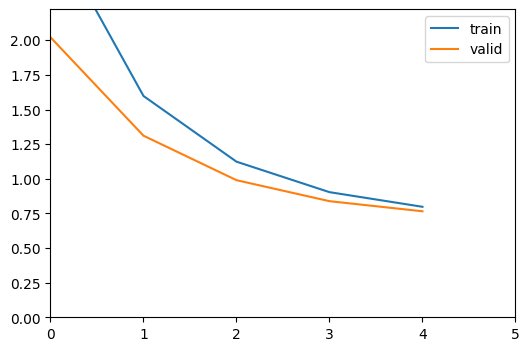

trial_out_num: 1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

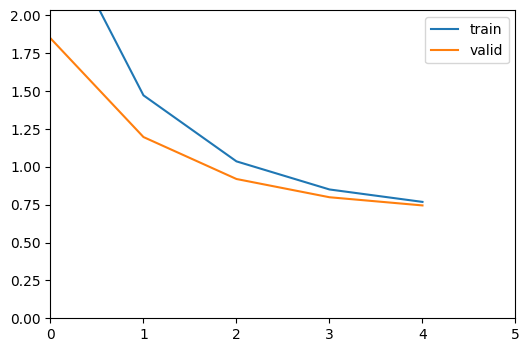

trial_out_num: 2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

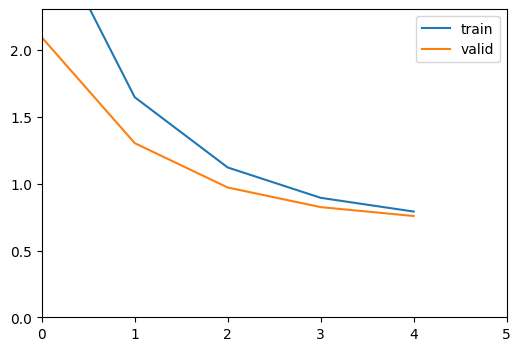

trial_out_num: 3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

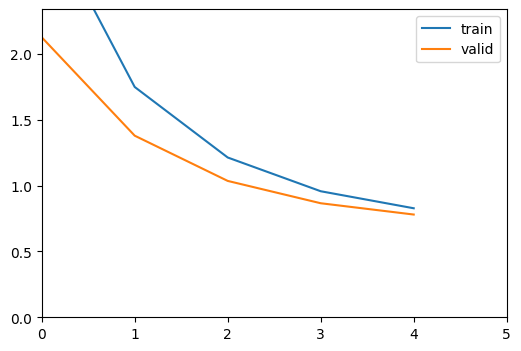

trial_out_num: 4
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

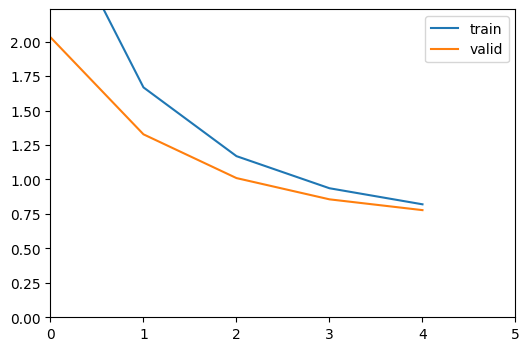

trial_out_num: 5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

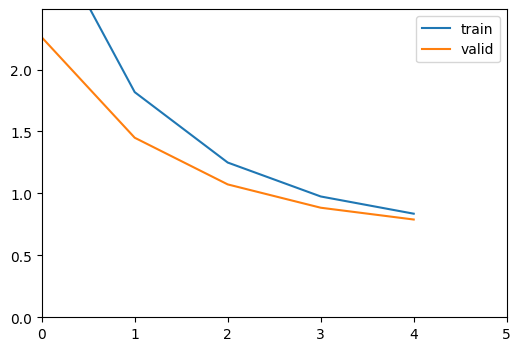

trial_out_num: 6
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

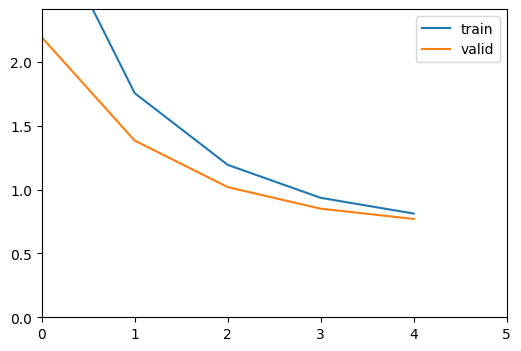

trial_out_num: 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

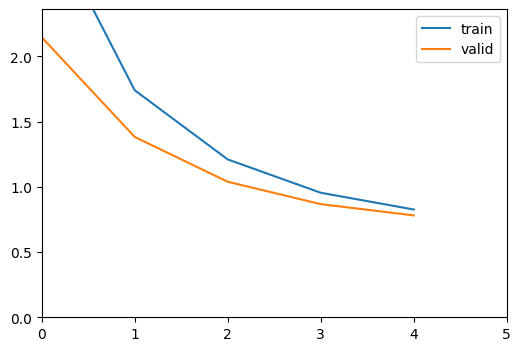

trial_out_num: 8
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                             

In [230]:
confusion_matrix = pd.DataFrame(np.zeros(shape=(nb_classes, nb_classes)), index=list(map(lambda str:'pred_'+str,classes)), columns=list(map(lambda str:'true_'+str,classes)))
out_root_dir='../results/'
# time to make each model
# make an evaluate excel
index_list=[str(i)+'_out' for i in range(0,10)]
index_list.append('overall')
df = pd.DataFrame(data=np.zeros(shape=(11, 9), dtype=np.float32),
                  index=index_list,
                  columns=['accuracy', 'precision', 'recall', 'f_measure','TP','FP','FN','TN','process_time'])
for trial_num in range(0,10):
    print('trial_out_num: '+str(trial_num))
    x_train,y_train,x_test,y_test,x_val,y_val = make_datasets(test_num=trial_num)

    # get the hyperparameters
    architecture = random.choice(architectures)
    reg = random.choice(regs)
    lr = random.choice(lrs)
    filters = int(random.choice(filterss))
    kernel_size = int(random.choice(kernel_sizes))
    amsgrad = random.choice(amsgrads)

    out_dir = out_root_dir \
            + 'architecture__' + architecture + '/' \
            + 'reg__' + str(reg) + '/' \
            + 'lr__' + str(lr) + '/' \
            + 'filters__' + str(filters) + '/' \
            + 'kernel_size__' + str(kernel_size) + '/' \
            + 'amsgrad__' + str(amsgrad) + '/' \
            + str(trial_num) + '_out' + '/'

    test_dir = create_dir(out_dir)
    # if (test_dir is None):
    #     itrr = itrr - 1
    #     continue

    keras.backend.clear_session()

    build_model = modified_fcn_each_dim_build_model
    # build_model=attention_lstm_fcn_each_dim_build_model

    model = build_model(input_shapes, filters, kernel_size, lr, amsgrad, summary=False, reg=reg)
    # save init parameters
    model.save(out_dir + 'model_init.hdf5')

    # 学習曲線描画のための前準備
    mb = master_bar(range(nb_epochs))
    train_costs_lst = []
    valid_costs_lst = []
    test_costs_lst=[]
    x_bounds = [0, nb_epochs]
    y_bounds = None
    y_upper_bound=None
    min_val_loss=-1

    start = time.time()

    for epoch in mb:
        # shuffle before every epoch training
        if (shuff == True):
            x_train, y_train = shuffle(x_train, y_train)
        # convert string labels to binary forms
        y_train_binary, y_test_binary, y_val_binary = convertStringClassesToBinaryClasses(y_train, y_test, y_val)

        epoch_train_loss = 0
        epoch_test_loss = 0
        epoch_val_loss = 0
        train_num=0
        # train_num=iteration_num because batchsize=1
        for iteration in progress_bar(range(len(x_train)), parent=mb):
            loss, acc = model.train_on_batch(split_input_for_training(x_train[train_num]), y_train_binary[train_num].reshape(1, nb_classes))
            epoch_train_loss += loss  ################# change if monitor acc instead of loss
            train_num+=1
        
        epoch_train_loss = epoch_train_loss / len(x_train)
        epoch_test_loss=evaluate_for_epoch(model, x_test, y_test_binary)

        if val_split:
            epoch_val_loss = evaluate_for_epoch(model, x_val, y_val_binary)
            if (epoch_val_loss < min_val_loss or min_val_loss == -1):
                # this is to choose finally the model that yields the best results on the validation set
                model.save(out_dir + 'model_best.hdf5')
                min_val_loss = epoch_val_loss
        else:  # we evaluate on the train
            if (epoch_train_loss < min_val_loss or min_val_loss == -1):
                # this is to choose finally the model that yields the best results on the validation set
                model.save(out_dir + 'model_best.hdf5')
                min_val_loss = epoch_train_loss

        model.save(out_dir + 'model_curr.hdf5')

        # 損失関数の値の計算
        train_costs_lst.append(epoch_train_loss)
        test_costs_lst.append(epoch_test_loss)

        # learning curveの図示
        if y_bounds is None:
            # 1エポック目のみ実行
            y_bounds = [0, epoch_test_loss *
                        1.1 if y_upper_bound is None else y_upper_bound]

        t = np.arange(len(train_costs_lst))
        graphs = [[t, train_costs_lst], [t, test_costs_lst]]
        mb.update_graph(graphs, x_bounds, y_bounds)

        # 学習過程の出力
        # mb.write('EPOCH: {0:02d}, Training cost: {1:10.5f}, Validation cost: {2:10.5f}'.format(
        #     epoch+1, epoch_train_loss, epoch_test_loss))

    process_time = time.time() - start

    model = load_model(out_dir + 'model_best.hdf5')

    confusion_matrix_f = evaluateModel(model, x_test, y_test_binary)
    evaluate_confusion_matrix(df,str(trial_num)+'_out',confusion_matrix_f,process_time)

out_dir = out_root_dir \
            + 'architecture__' + architecture + '/' \
            + 'reg__' + str(reg) + '/' \
            + 'lr__' + str(lr) + '/' \
            + 'filters__' + str(filters) + '/' \
            + 'kernel_size__' + str(kernel_size) + '/' \
            + 'amsgrad__' + str(amsgrad) + '/'
evaluate_confusion_matrix(df,'overall',confusion_matrix,process_time=None)